In [1]:
import matplotlib.pyplot as plt
import numpy as np

#Load the data
X = np.loadtxt('X.txt')
y = np.loadtxt('y.txt')

#Permute the data
permutation = np.random.permutation(X.shape[0])
X = X[permutation, : ]
y = y[permutation]

#Split into training and test sets
n_train = 800
X_train = X[ 0 : n_train, : ]
X_test = X[ n_train :, : ]
y_train = y[ 0 : n_train ]
y_test = y[ n_train : ]

In C:\Users\Matt\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Matt\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Matt\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Matt\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Matt\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle

## Data Plotting

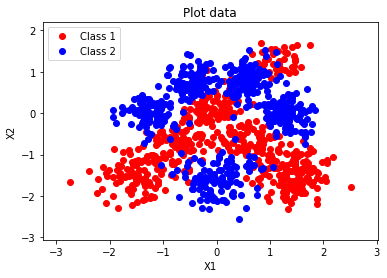

In [2]:
def plot_data_internal(X, y):
    x_min, x_max = X[ :, 0 ].min() - .5, X[ :, 0 ].max() + .5
    y_min, y_max = X[ :, 1 ].min() - .5, X[ :, 1 ].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    plt.figure()
    plt.xlim(xx.min(None), xx.max(None))
    plt.ylim(yy.min(None), yy.max(None))
    ax = plt.gca()
    ax.plot(X[y == 0, 0], X[y == 0, 1], 'ro', label = 'Class 1')
    ax.plot(X[y == 1, 0], X[y == 1, 1], 'bo', label = 'Class 2')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Plot data')
    plt.legend(loc = 'upper left', scatterpoints = 1, numpoints = 1)
    return xx, yy

def plot_data(X, y):
    xx, yy = plot_data_internal(X, y)
    plt.show()
       
plot_data(X, y)

## Logistic function & Log-Likelihood

In [3]:
#Logistic function
def logistic(x): return 1.0 / (1.0 + np.exp(-x))

#Make predictions using the logistic classifier
#Where X_tilde is the matrix (so we can do more than one point at once) of input features
#and w is a vector of model parameters
def predict(X_tilde, w): return logistic(np.dot(X_tilde, w))

#Function to compute the average log likelihood of the input data points
#Where X_tilde is the matrix of input features
#y is a vector of output class labels
#w is a vector of model parameters
def compute_average_ll(X_tilde, y, w):
    output_prob = predict(X_tilde, w) #Make predictions using the logistic classifier
    return np.mean(y*np.log(output_prob) + (1-y)*np.log(1-output_prob)) #Return the average log likelihood (see slides)

#Plots the log-likelihood detailed by the history vector ll
def plot_ll(ll):
    plt.figure()
    ax = plt.gca()
    plt.xlim(0, len(ll) + 2)
    plt.ylim(min(ll) - 0.1, max(ll) + 0.1)
    ax.plot(np.arange(1, len(ll) + 1), ll, 'r-')
    plt.xlabel('Steps')
    plt.ylabel('Average log-likelihood')
    plt.title('Plot Average Log-likelihood Curve')
    plt.show()

#Function to append a column of ones to a matrix of input features
def get_x_tilde(X): return np.concatenate((np.ones((X.shape[ 0 ], 1 )), X), 1)

## Basis functions

In [4]:
#To apply some basis functions, all we need to do is write a function that takes the inputs X as a parameter 
#Along with any extra parameters for specific basis functions (e.g. length scales)
#And returns a matrix of new features

#e.g. for quadratic basis functions we would pass X = [x_1, x_2, x_3, ...]^T where x_i is the i^th datapoint
# and our function should return 
# phi(x) = [x_1 (x_1)^2
    #       x_2 (x_2)^2
    #       ...
    #       ]
    
# (we can append the column of ones AFTER the feature expansion)
    
    
#Function to evaluate radial (Gaussian) basis functions
#Where l is a hyperparameter governing the width of the radial functions
#Z contains their respective locations in the input space
#X contains the points at which to evaluate them

def evaluate_radial_basis_functions(l, X, Z):
    X2 = np.sum(X**2, 1)
    Z2 = np.sum(Z**2, 1)
    ones_Z = np.ones(Z.shape[ 0 ])
    ones_X = np.ones(X.shape[ 0 ])
    r2 = np.outer(X2, ones_Z) - 2 * np.dot(X, Z.T) + np.outer(ones_X, Z2)
    return np.exp(-0.5 / l**2 * r2)

## Plot the predictive distribution for the classifier

In [5]:
#Plots the predictive distribution for the classifier
#X is the matrix of inputs (WITHOUT a column of ones appended)
#y contains the class labels 
#w is the parameter vector
#map_inputs - expands the orginal 2D inputs using basis functions
def plot_predictive_distribution(X, y, w, map_inputs = lambda x : x):
    xx, yy = plot_data_internal(X, y)
    ax = plt.gca()
    X_tilde = get_x_tilde(map_inputs(np.concatenate((xx.ravel().reshape((-1, 1)), yy.ravel().reshape((-1, 1))), 1)))
    Z = predict(X_tilde, w)
    Z = Z.reshape(xx.shape)
    cs2 = ax.contour(xx, yy, Z, cmap = 'RdBu', linewidths = 2)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 14)
    plt.show()

## Fit parameters by gradient ascent

![derivation.png](derivation.png)

In [6]:
#Fits model parameters using gradient descent/ascent

#X_tilde_train - matrix of training input features (inc. ones)
#y_train- vector of training output labels

#X_tilde_test - matrix of test input features
#y_test - vector of test output labels

#alpha - learning rate for gradient ascent
#n_steps - number of steps taken by gradient ascent algorithm

#Outputs
#1 - vector of maximum-likelihood model parameters
#2 - history vector of average log-likelihood on training set
#3 - history vector of average log-likelihood on test set

def fit_w(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha):
    w = np.random.randn(X_tilde_train.shape[ 1 ])
    ll_train = np.zeros(n_steps)
    ll_test = np.zeros(n_steps)
    for i in range(n_steps):
        sigmoid_value = predict(X_tilde_train, w) #See derivation
        
        diff = y_train - sigmoid_value #See derivation
        
        gradient = np.matmul(X_tilde_train.T, diff) #See derivation

        w = w + alpha * gradient #Gradient ascent update

        ll_train[ i ] = compute_average_ll(X_tilde_train, y_train, w)
        ll_test[ i ] = compute_average_ll(X_tilde_test, y_test, w)
        #print(ll_train[ i ], ll_test[ i ])

    return w, ll_train, ll_test

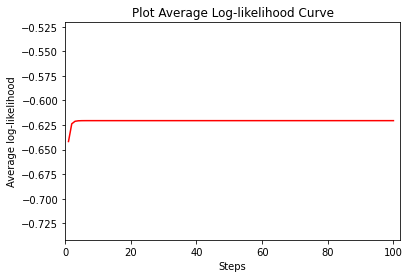

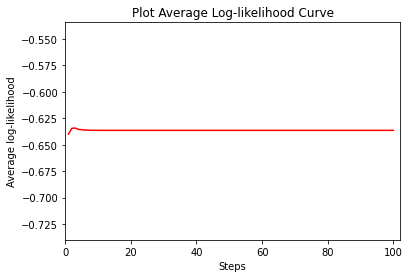

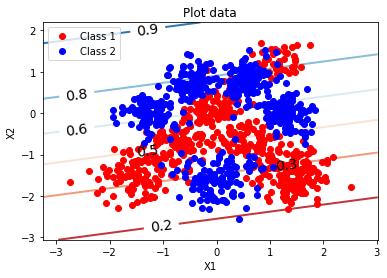

In [7]:
alpha = 0.005# XXX Learning rate for gradient-based optimisation. To be completed by the student
n_steps = 100# XXX Number of steps of gradient-based optimisation. To be completed by the student

X_tilde_train = get_x_tilde(X_train)
X_tilde_test = get_x_tilde(X_test)
w, ll_train, ll_test = fit_w(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha)

plot_ll(ll_train)
plot_ll(ll_test)

plot_predictive_distribution(X, y, w)


### Confusion Matrix

#### Training set

In [17]:
from sklearn.metrics import confusion_matrix

y_train_true = y_train #True labels for the training set
y_train_predicted = np.round(predict(X_tilde_train, w)) #Predicted labels for training set

a_confusion_matrix = confusion_matrix(y_train_true, y_train_predicted)

normalised_confusion_matrix = a_confusion_matrix/a_confusion_matrix.sum(axis=1) #Normalise by true values (rows)

print(normalised_confusion_matrix)

[[0.71571072 0.28571429]
 [0.27930175 0.71929825]]


#### Test set

In [16]:
y_test_true = y_test #True labels for the training set
y_test_predicted = np.round(predict(X_tilde_test, w)) #Predicted labels for training set

a_confusion_matrix = confusion_matrix(y_test_true, y_test_predicted)

normalised_confusion_matrix = a_confusion_matrix/a_confusion_matrix.sum(axis=1) #Normalise by true values (rows)

print(normalised_confusion_matrix)

[[0.62857143 0.41052632]
 [0.23809524 0.73684211]]


## Radial Basis Functions

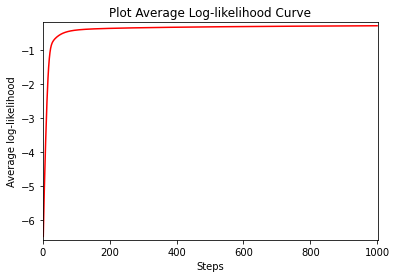

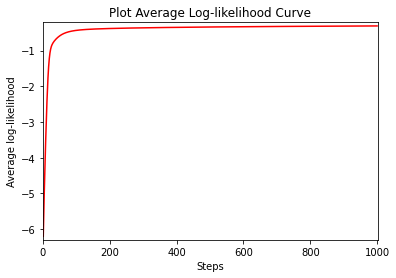

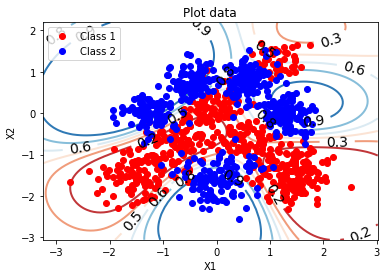

In [18]:
l = 1 #Length scale for the radial basis functions
alpha = 0.00005
n_steps = 1000

X_tilde_train = get_x_tilde(evaluate_radial_basis_functions(l, X_train, X_train)) #New feature matrices using the RBFs
X_tilde_test = get_x_tilde(evaluate_radial_basis_functions(l, X_test, X_train))

w, ll_train, ll_test = fit_w(X_tilde_train, y_train, X_tilde_test, y_test, n_steps, alpha)

plot_ll(ll_train)
plot_ll(ll_test)

plot_predictive_distribution(X, y, w, lambda x : evaluate_radial_basis_functions(l, x, X_train)) #Using the basis functions as mapping


### Confusion Matrix

#### Training set

In [19]:
from sklearn.metrics import confusion_matrix

y_train_true = y_train #True labels for the training set
y_train_predicted = np.round(predict(X_tilde_train, w)) #Predicted labels for training set

a_confusion_matrix = confusion_matrix(y_train_true, y_train_predicted)

normalised_confusion_matrix = a_confusion_matrix/a_confusion_matrix.sum(axis=1) #Normalise by true values (rows)

print(normalised_confusion_matrix)

[[0.88279302 0.11779449]
 [0.0798005  0.9197995 ]]


#### Test set

In [20]:
y_test_true = y_test #True labels for the training set
y_test_predicted = np.round(predict(X_tilde_test, w)) #Predicted labels for training set

a_confusion_matrix = confusion_matrix(y_test_true, y_test_predicted)

normalised_confusion_matrix = a_confusion_matrix/a_confusion_matrix.sum(axis=1) #Normalise by true values (rows)

print(normalised_confusion_matrix)

[[0.86666667 0.14736842]
 [0.0952381  0.89473684]]
